# Homework #15: ***Computing resources***
## Author of the code:  *Xenia De Gracia Medina*.
## Date: *December 07, 2020*.

#### - **Purpose of the notebook:**
In this code, we try to forecast the flow values of the Verde River through the use of a linear regression model taking into account factors like the air temperature, soil moisture, and precipitation.

#### - **How you are generating forecasts and why?**
My forecast is done through the use of an autoregression of the daily flow values, converted to a logarithm scale. The reason for that procedure is due to the flow is not behaving linear, hence the logarithm scale has allowed us a better fit to the data.

#### - **A discussion of how you have done so far and how your forecasting has evolved over time.**
- I can tell that at the beginning I was not able to obtain ***data from a direct link to the server***, instead of that I had to download the file manually to my computer, and that didn't let other people run my code from their device without that file.
- Besides, on my first forecast, I was just obtaining flow values without taking into account other factors that could explain to myself the reason for the increase or the decrease of the flow. Now that I have learned to obtain data from ***different dataset sources***, I could make better decisions knowing the factors that could affect my model.
- I have seen the ***evolution on my coefficient of determination***. The new logarithm scale has developed on the model a coefficient of 0.92, however, my past models had a coefficient of determination of 0.32 and 0.63.
- ***Maps and plottings*** have allowed better visualization of the situation that we are studying, instead of seeing just a lot of numbers in a giant excel table from the firsts assignments.
- Finally, the improvement on the way of coding thanks to the ***PEP8 guidelines***, allow me to have a better presentation of my scripts making life easier for my future self and other users.

## 1. Update the necessary variables to make the code work

In [4]:
# NOTE Update this date
end_date = '2020-12-03'

## 2. Import the tools we will use

In [5]:

import Functions as function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime
import math
import json
import urllib.request as req
import urllib
import seaborn as sn
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sn
import geopandas as gpd
import fiona
import contextily as ctx
import shapely
from shapely.geometry import Point
from netCDF4 import Dataset

ModuleNotFoundError: No module named 'Functions'

## 3. Getting the datasets to perform the modeling

### 3.1 Volumetric Soil Moisture from a NetCDF file

The data was downloaded from https://psl.noaa.gov/cgi-bin/db_search/DBSearch.pl?Dataset=NCEP+Reanalysis+Daily+Averages&Variable=Volumetric+Soil+Moisture&group=0&submit=Search

The data is already saved at the same directory as the Jupyter Notebook

In [2]:
ook

# Net CDF file historical time series
data_path = os.path.join('../../../Geodatabases',
                         'Reanalysis_VolumetricSoilMoisture.nc')

# Read in the dataset as an x-array
dataset = xr.open_dataset(data_path)
# look at it
dataset

# We can inspect the metadata of the file like this:
metadata = dataset.attrs
metadata

# Focusing on just the Soil Moisture values
SoilMois = dataset['soilw']
SoilMois

# Now lets take a slice: Grabbing data for just one point
lat = dataset["soilw"]["lat"].values[0]
lon = dataset["soilw"]["lon"].values[0]
print("Long, Lat values:", lon, lat)
one_pointSM = dataset["soilw"].sel(lat=lat, lon=lon)
one_pointSM.shape

SoilMois_val = one_pointSM.values

# Convert to dataframe
Soil_Moist_df = one_pointSM.to_dataframe()
Soil_Moist_W = Soil_Moist_df.resample("W-SUN").mean().round(2)

# Adding timezone = UTC to the flow data, to join the Mesowest data after
Soil_Moist_W.index = Soil_Moist_W.index.tz_localize(tz="UTC")


Long, Lat values: 247.5 35.2375


## 3.2 Flow Data from USGS

Read the data from the website, into a pandas dataframe.

In [3]:
# Calling the function to get the Flow data from USGS
data, flow_daily, flow_weekly = function.read_flow_data(end_date)

The flow data is obtained  from:  https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09506000&referred_module=sw&period=&begin_date=1989-01-01&end_date=2020-11-21

                          agency_cd  site_no  log_flow   datetime   flow code  \
datetime                                                                        
1989-01-01 00:00:00+00:00      USGS  9506000  5.332719 1989-01-01  207.0    A   
1989-01-02 00:00:00+00:00      USGS  9506000  5.323010 1989-01-02  205.0    A   
1989-01-03 00:00:00+00:00      USGS  9506000  5.323010 1989-01-03  205.0    A   
1989-01-04 00:00:00+00:00      USGS  9506000  5.446737 1989-01-04  232.0    A   
1989-01-05 00:00:00+00:00      USGS  9506000  5.556828 1989-01-05  259.0    A   
...                             ...      ...       ...        ...    ...  ...   
2020-11-17 00:00:00+00:00      USGS  9506000  5.081404 2020-11-17  161.0    P   
2020-11-18 00:00:00+00:00      USGS  9506000  5.036953 2020-11-18  154.0    P   
2020-11-19 

## 4. Autoregression modeling to obtain the flow forecast

In [4]:
# Step 1: setup the arrays you will build your model on. Building it
# based on the lagged timeseries.

flow_daily['flow_tm1'] = flow_daily['log_flow'].shift(1)
flow_daily['flow_tm2'] = flow_daily['log_flow'].shift(2)

# Step 2: Taking train data from August to December 2019 because it was a dry \
# year too.
train = flow_daily.loc["2019-08-22":"2019-12-12"][['log_flow', 'flow_tm1',
                                                   'flow_tm2']]
# This shows the start and end of the training data.
print("The training data was taken from: ", train.index.min(), "  to  ",
      train.index.max())
print()

# Xenia: Taking data from last 3 years to test (3 years=1095 days)
test = flow_daily[-1095:][['log_flow', 'flow_tm1', 'flow_tm2']]

# Step 3: Fit a linear regression model using sklearn
x = train['flow_tm1'].values.reshape(-1, 1)
y = train['log_flow'].values
# Xenia: Shorten the steps to create the regression model
model = LinearRegression().fit(x, y)

# Look at the results
# r^2 values
r_sq = model.score(x, y)
print('coefficient of determination:', np.round(r_sq, 2))

# Print the intercept and the slope
print('intercept:', np.round(model.intercept_, 2))
print('slope:', np.round(model.coef_, 2))

# Step 4 Make a prediction with your model
# Predict the model response for a  given flow value
q_pred_train = model.predict(train['flow_tm1'].values.reshape(-1, 1))
q_pred_test = model.predict(test['flow_tm1'].values.reshape(-1, 1))

# alternatively you can calcualte this yourself like this:
# Xenia: y = b + m(x)
q_pred = (model.intercept_) + (model.coef_ * train['flow_tm1'])
q_pred_W = q_pred.resample("W-SUN").min().round(2)
# Xenia: Printing the equation of the model
Equation = 'y = ' + str((model.intercept_).round(2)) + ' + ' + str(model.coef_.round(2)) + 'X'
print('The AR model equation is: ', Equation)
# Xenia: Printing my prediction value. (I used the mean value of the range.)
print('Prediction using equation from Linear Regression is:',
      np.exp(q_pred_W))
print(type(q_pred_W))

The training data was taken from:  2019-08-22 00:00:00+00:00   to   2019-12-12 00:00:00+00:00

coefficient of determination: 0.92
intercept: 0.18
slope: [0.97]
The AR model equation is:  y = 0.18 + [0.97]X
Prediction using equation from Linear Regression is: datetime
2019-08-25 00:00:00+00:00      31.816977
2019-09-01 00:00:00+00:00      34.123968
2019-09-08 00:00:00+00:00      54.054889
2019-09-15 00:00:00+00:00      51.418601
2019-09-22 00:00:00+00:00      51.418601
2019-09-29 00:00:00+00:00      54.054889
2019-10-06 00:00:00+00:00      75.944287
2019-10-13 00:00:00+00:00      80.640419
2019-10-20 00:00:00+00:00      76.707539
2019-10-27 00:00:00+00:00      80.640419
2019-11-03 00:00:00+00:00     100.484150
2019-11-10 00:00:00+00:00     126.469352
2019-11-17 00:00:00+00:00     132.953574
2019-11-24 00:00:00+00:00     144.026887
2019-12-01 00:00:00+00:00     181.272242
2019-12-08 00:00:00+00:00     437.029195
2019-12-15 00:00:00+00:00    1053.633557
Freq: W-SUN, Name: flow_tm1, dtype:

In [5]:
# Prediction of the q for just a single value
# Xenia: I used the mean value of the last 3 WEEKS to forecast the coming
# week.
# Xenia: I made the same to predict the second week value, but using the
# minimun flow of the data from the LAST week only.
last_week_flow = flow_daily['log_flow'][-21].mean()
last2_weeks_flow = flow_daily['log_flow'][-8].min()
prediction1stweek = math.exp(model.intercept_ + (model.coef_ * last_week_flow))
prediction2ndweek = math.exp(model.intercept_ + (model.coef_ * last2_weeks_flow))
# Xenia: Printing the equation of the model
print('First week prediction based on my AR model:',
      np.round(prediction1stweek,2), 'ft3/s')
print('Second week prediction based on my on my AR model:',
      np.round(prediction2ndweek,2), 'ft3/s')

First week prediction based on my AR model: 130.01 ft3/s
Second week prediction based on my on my AR model: 159.6 ft3/s


In [6]:
# To compare with my initial method using just average of the last weeks:

# AVERAGE FIRST WEEK FORECAST
flow_mean1 = np.round(((data['flow'].tail(21)).mean()), 2)
print('The AVERAGE forecast for the FIRST week that comes is:', flow_mean1,
      'ft3/s')
print()

# AVERAGE  SECOND WEEK FORECAST
flow_mean2 = np.round(((data['flow'].tail(14)).mean()), 2)
print('The AVERAGE forecast for the SECOND week that comes is:', flow_mean2,
      'ft3/s')
print()

The AVERAGE forecast for the FIRST week that comes is: 146.0 ft3/s

The AVERAGE forecast for the SECOND week that comes is: 155.71 ft3/s



## 5. Visualization of the data through plots

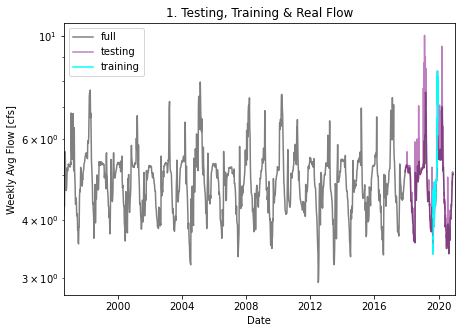

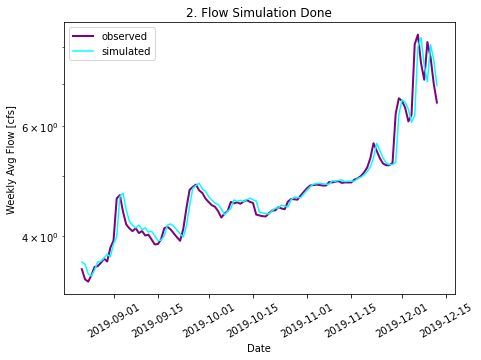

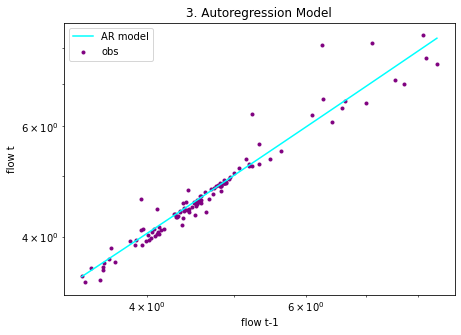

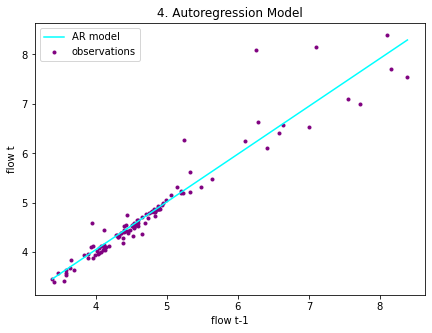

In [7]:
# PLOTS

# 1. Time series of flow values with the x axis range limited
fig, ax = plt.subplots()
ax.plot(flow_weekly['log_flow'], label='full', color='grey')
ax.plot(test['log_flow'], 'r:', label='testing', color='purple', linestyle='-',
        alpha=0.50, dash_capstyle='round')
ax.plot(train['log_flow'], 'r:', label='training', color='aqua', linestyle='-',
        alpha=1, dash_capstyle='round')
ax.set(title="1. Testing, Training & Real Flow", xlabel="Date",
       ylabel="Weekly Avg Flow [cfs]", yscale='log',
       xlim=[datetime.date(1996, 8, 24), datetime.date(2021, 1, 1)])
ax.legend()
fig.set_size_inches(7, 5)
fig.savefig("1. Testing, Training & Real Flow.png")

# 2. Line  plot comparison of predicted and observed flows
fig, ax = plt.subplots()
ax.plot(train['log_flow'], color='purple', linewidth=2, label='observed')
ax.plot(train.index, q_pred_train, color='aqua', linestyle='-',
        label='simulated')
ax.set(title="2. Flow Simulation Done", xlabel="Date",
       ylabel="Weekly Avg Flow [cfs]", yscale='log')

plt.xticks(rotation=30)
ax.legend()
# Xenia: Saving my plots
fig.set_size_inches(7, 5)
fig.savefig("2. Flow Simulation Done.png")

# 3. Scatter plot of t vs t-1 flow with log log axes
fig, ax = plt.subplots()
ax.scatter(train['flow_tm1'], train['log_flow'], marker='.',
           color='purple', label='obs')
ax.set(title="3. Autoregression Model", xlabel='flow t-1', ylabel='flow t',
       yscale='log', xscale='log')
ax.plot(np.sort(train['flow_tm1']), np.sort(q_pred_train), label='AR model',
        color='aqua')
ax.legend()
# Xenia: Saving my plots
fig.set_size_inches(7, 5)
fig.savefig("3. Autoregression Model.png")

# 4. Scatter plot of t vs t-1 flow with normal axes
fig, ax = plt.subplots()
ax.scatter(train['flow_tm1'], train['log_flow'], marker='.',
           color='purple', label='observations')
ax.set(title="4. Autoregression Model", xlabel='flow t-1', ylabel='flow t')
ax.plot(np.sort(train['flow_tm1']), np.sort(q_pred_train), label='AR model',
        color='aqua')
ax.legend()
# Xenia: Saving my plots
fig.set_size_inches(7, 5)
fig.savefig("4. Autoregression Model.png")

plt.show()

The Mesowest data is obtained from:  http://api.mesowest.net/v2/stations/timeseries?start=199701010000&end=202011210000&obtimezone=UTC&vars=air_temp%2Cprecip_accum&stids=QVDA3&units=temp%7CC%2Cprecip%7Cmm&token=demotoken


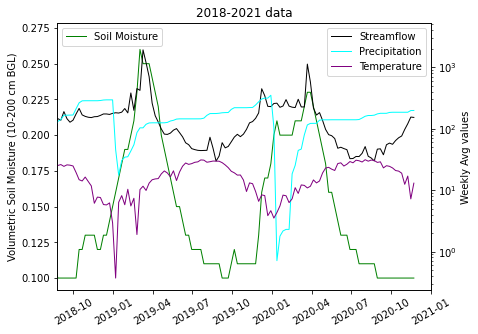

In [8]:
# Making PLOTS with Mesowest and USGS Data

# Calling the function to get Precipitation and Temperature data from Mesowest
data_Meso, data_Meso_D, data_Meso_W = function.prec_temp_data(end_date)

# Printing my dataframe to know it
data_Meso_D

fig, ax = plt.subplots()
ax.plot(Soil_Moist_W['soilw'], 'r:', label='Soil Moisture',
        color='green', linestyle='-', alpha=1, linewidth=1)
ax.legend(loc=2)
ax.set(ylabel="Volumetric Soil Moisture (10-200 cm BGL)")
plt.xticks(rotation=30)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(flow_weekly['flow'], label='Streamflow', color='black',
         linewidth=1)
ax2.plot(data_Meso_W['Precipitation'], 'r:', label='Precipitation',
         color='aqua', linestyle='-', alpha=1, linewidth=1)
ax2.plot(data_Meso_W['Temperature'], 'r:', label='Temperature',
         color='purple', linestyle='-', alpha=1, linewidth=1)
ax2.legend()
ax2.set(title="2018-2021 data", xlabel="Date", ylabel="Weekly Avg values",
        yscale='log', xlim=[datetime.date(2018, 8, 24),
                            datetime.date(2021, 1, 1)])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(7, 5)
fig.savefig("2018-2021_Data.png")


In [9]:
# %%
# Concatenate a single dataframe with all the time series
union = pd.concat([flow_weekly[['flow']], data_Meso_W[['Temperature']],
                   data_Meso_W[['Precipitation']],
                   Soil_Moist_W[['soilw']]], axis=1)

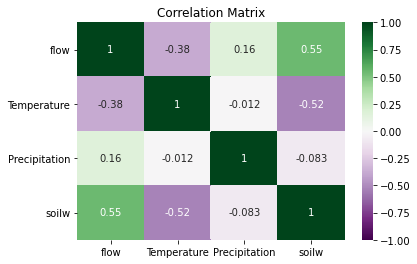

<Figure size 432x288 with 0 Axes>

In [10]:
# Correlation Plot
corrMatrix = union.corr()
sn.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center=0, cmap='PRGn')
plt.title("Correlation Matrix")
plt.show()
fig.set_size_inches(7, 5)
plt.savefig("Correlation_Matrix.png", bbox_inches='tight', pad_inches=0.0)

## 6. Map of the area of study

### 6.1 Gauges II USGS stream gauge dataset:
Downloaded here: https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder

Link used: https://water.usgs.gov/GIS/dsdl/gagesII_9322_point_shapefile.zip

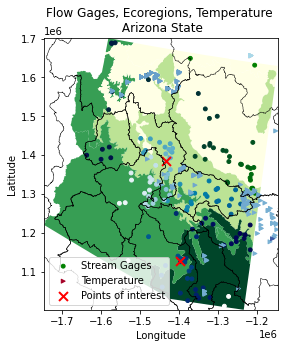

In [11]:
# Reading it using geopandas
file = os.path.join('../../../Geodatabases/gagesII_9322_point_shapefile',
                    'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)

# %%
# Let look at what this is
type(gages)
gages.head()
gages.columns
gages.shape

# Looking at the geometry now
gages.geom_type
# check our CRS - coordinate reference system
gages.crs
# Check the spatial extent
gages.total_bounds
# NOTE to selves - find out how to get these all at once

# Zoom  in and just look at AZ
gages.columns
gages.STATE.unique()
gages_AZ = gages[gages['STATE'] == 'AZ']
gages_AZ.shape


### 6.2 Watershed boundaries for the lower Colorado. Polygon layer.

Adding more datasets downloaded from:
https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products

Final link used: https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/GDB/WBD_15_HU2_GDB.zip


In [ ]:
# NOTE: HUC means Hydrologic Unit Code

# Calling the dataset from the directory.
file = os.path.join('../../../Geodatabases/WBD_15_HU2_GDB', 'WBD_15_HU2_GDB.gdb')
os.path.exists(file)
fiona.listlayers(file)

# Reading in a geodataframe
HUC6 = gpd.read_file(file, layer="WBDHU6")

type(HUC6)
HUC6.head()

# Showing the Coordinate Reference System and the Total Bounds
HUC6.crs
HUC6.total_bounds

### 6.3  Adding some points of interest to the map

University of Arizona:  32.22877495, -110.97688412

Verde River Stream gauge:  34.44833333, -111.7891667

In [ ]:
# Creating the coordinates of the points as a numpy array
point_list = np.array([[-110.97688412, 32.22877495],
                       [-111.7891667, 34.44833333]])

# make these into spatial features
point_geom = [Point(xy) for xy in point_list]
point_geom

# make a dataframe of these points
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'],
                            crs=HUC6.crs)

# %%
# Trouble!! we are in two differnt CRS
gages_AZ.crs
point_df.crs

# Re-project to same CRS
points_project = point_df.to_crs(gages_AZ.crs)

# NOTE: .to_crs() will only work if your original spatial object has a CRS \
# assigned to it AND if that CRS is the correct CRS!

### 6.4 Adding Ecoregions of Arizona. Polygon layer.

From: https://www.epa.gov/eco-research/ecoregion-download-files-state-region-9

In [ ]:
# Calling the dataset from the directory.
file = os.path.join('../../../Geodatabases/az_eco_l3', 'az_eco_l3.shp')
os.path.exists(file)
fiona.listlayers(file)
eco_AZ = gpd.read_file(file, layer="az_eco_l3")

type(eco_AZ)
eco_AZ.head()

# Reviewing the Coordinate Reference System
eco_AZ.crs

# Changing all the layers to the same CRS as "Gages" layer.
eco_AZ_project = eco_AZ.to_crs(gages_AZ.crs)

### 6.5 Temperatures of Arizona. Point layer.

From: https://data.fs.usda.gov/geodata/edw/datasets.php?xmlKeyword=arizona

In [ ]:
# Calling the dataset from the directory.
file = os.path.join('../../../Geodatabases/S_USA.NorWeST_TemperaturePoints.gdb',
                    'S_USA.NorWeST_TemperaturePoints.gdb')
os.path.exists(file)
fiona.listlayers(file)
temp_AZ = gpd.read_file(file, layer="NorWeST_TemperaturePoints")

type(temp_AZ)
temp_AZ.head()

# Reviewing the Coordinate Reference System
temp_AZ.crs

# Changing all the layers to the same CRS as "Gages" layer.
temp_AZ_project = temp_AZ.to_crs(gages_AZ.crs)

# Changing all the layers to the same CRS as "Gages" layer.
HUC6_project = HUC6.to_crs(gages_AZ.crs)

### 6.6 Finally merging all the datasets in the same map

In [ ]:
# Now plot
# Adding each layer to the map
fig, ax = plt.subplots(figsize=(10, 5))
eco_AZ_project.plot(column='NA_L2NAME', categorical=True, legend=True,
                    label='Ecoregions', cmap='YlGn', ax=ax)
gages_AZ.plot(categorical=False, legend=True,
              label='Stream Gages', markersize=15, cmap='ocean', ax=ax)
temp_AZ_project.plot(categorical=False, legend=True, markersize=15, marker='>',
                     cmap='RdYlBu', ax=ax, label='Temperature')
points_project.plot(ax=ax, legend=True, label='Points of interest',
                    color='red', marker='x', markersize=80, linewidth=2)
HUC6_project.boundary.plot(ax=ax, color=None, edgecolor='black', linewidth=0.5)

# Making zoom to the bounds of the prefered layer. In this case Eco-regions.
xlim = ([eco_AZ_project.total_bounds[0],  eco_AZ_project.total_bounds[2]])
ylim = ([eco_AZ_project.total_bounds[1],  eco_AZ_project.total_bounds[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set(title='Flow Gages, Ecoregions, Temperature \n Arizona State',
       xlabel='Longitude', ylabel='Latitude')

# Show the legend
ax.legend()

# Show the plot
plt.show()